In [8]:
import tqdm
import gym
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [9]:
env = gym.make('Blackjack-v0')

In [10]:
env.action_space # 'hit' = 1, 'stick' = 0

Discrete(2)

In [11]:
nA = 2

In [12]:
env.observation_space
# the players current sum,
# the dealer's one showing card (1-10 where 1 is ace)
# whether or not the player holds a usable ace (0 or 1) // ace can either count as 11 or 1, and it's called 'usable' at 11.)

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [13]:
state_space_size = [32, 11, 2] # не все элементы пространства используются, см. комментарий ниже:

# axis=0
# В 'Blackjack-v0' минимальная сумма игрока = 4 (две двойки при раздаче), максимальная = 31 (добор 10 при 21 очке).
# Пространство возможных значений суммы карт игрока имеет размерность 28 состояний: [4 : 31].

# axis=1
# Первая карта дилера может быть любой картой из колоды (туз=1), поэтому возможные значения [1 : 10]

# axis=0
# "ace" не "ace" = 2

# 1.1 Оценка стратегии 19, 20, 21 (Monte Carlo estimation)

In [14]:
from utils import (
    observation_int,
    run_episode,
    update_returns,
    score_pi
)

In [28]:
# стратегия: говорить stand, если у нас на руках комбинация в 19, 20 или 21
pi = np.ones(state_space_size, int)
pi[[19, 20, 21], :, :] = 0

# корректировки ниже для отрисовки и сравнения стратегий (не влияют на вычисления)
# терминальные состояния
pi[22:, :, :] = 0
# не используемые состояния игрока
pi[[0, 1, 2, 3], :, :] = 0
# не используемые состояния дилера
pi[:, [0], :] = 0

In [29]:
# объявление переменных
gamma = 1
total_episodes = 1_000_000
total_reward = 0
V = np.zeros(state_space_size)
R_sum = np.zeros(state_space_size)
R_count = np.zeros(state_space_size)

# запуск экспериментов
for _ in range(total_episodes):
    states, rewards = run_episode(env, pi) # запускаю новый эпизод
    R_sum, R_count = update_returns(R_sum, R_count, states, rewards, gamma) # сохраняю его результаты
    total_reward += sum(rewards)

# находим V-функцию 
for dim0 in range(state_space_size[0]):
    for dim1 in range(state_space_size[1]):
        for dim2 in range(state_space_size[2]):
            if R_count[dim0, dim1, dim2] > 0:
                V[dim0, dim1, dim2] = R_sum[dim0, dim1, dim2] / R_count[dim0, dim1, dim2]
                
env.close()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  import sys


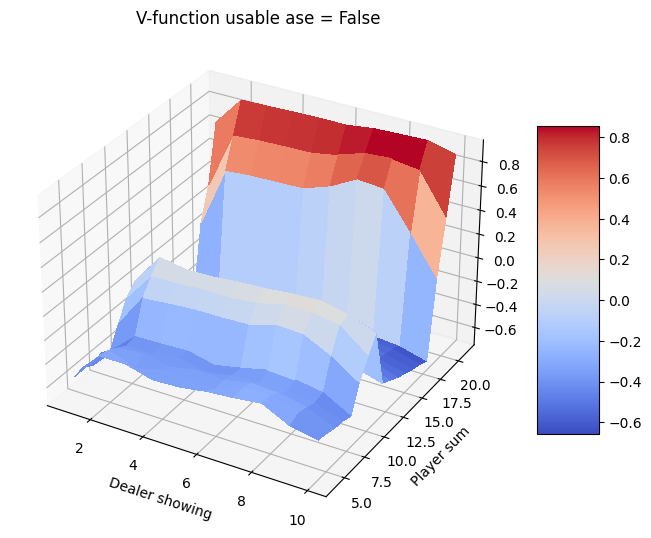

In [30]:
# построим график V функции
PLR = np.arange(4, 22)
DLR = np.arange(1, 11)
PLR, DLR = np.meshgrid(DLR, PLR)

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(PLR, DLR, V[4:22, 1:11, 0], rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_ylabel("Player sum")
ax.set_xlabel("Dealer showing")
ax.set_title("V-function usable ase = False")

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


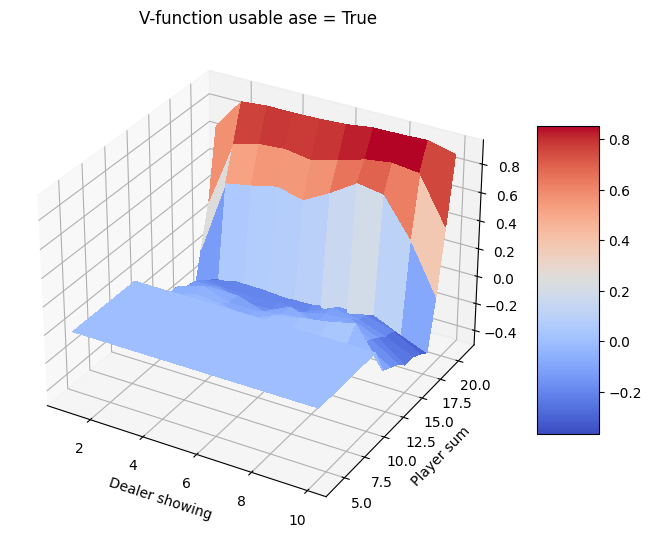

In [31]:
PLR = np.arange(4, 22)
DLR = np.arange(1, 11)
PLR, DLR = np.meshgrid(DLR, PLR)

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(PLR, DLR, V[4:22, 1:11, 1], rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_ylabel("Player sum")
ax.set_xlabel("Dealer showing")
ax.set_title("V-function usable ase = True")

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

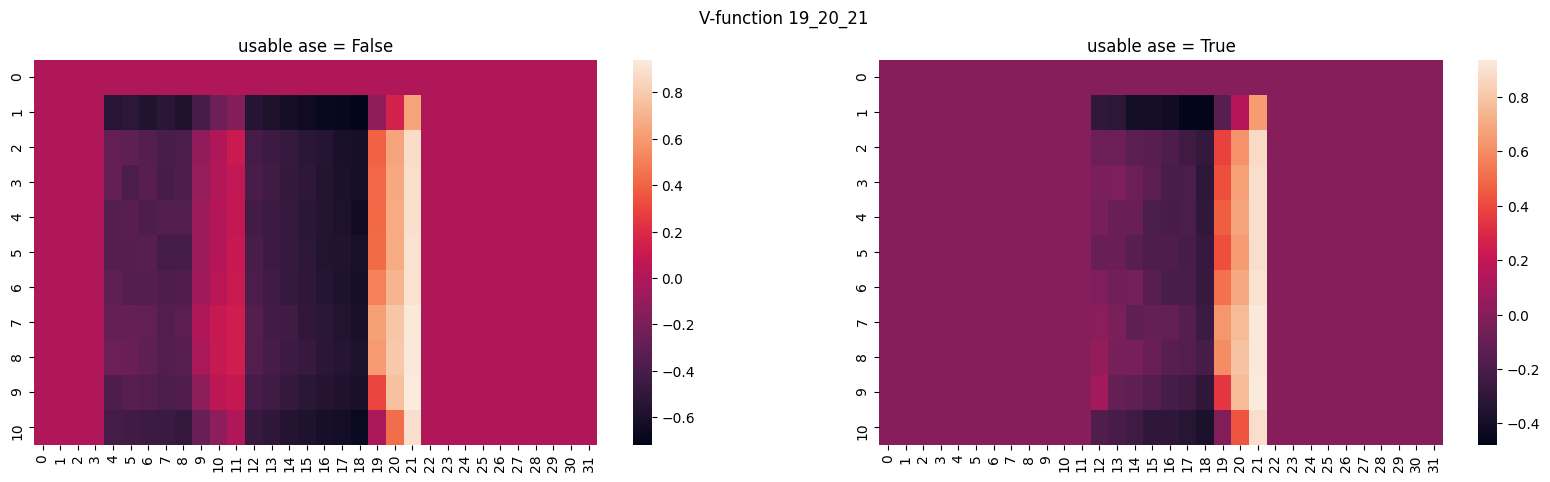

In [32]:
# значение V-функции
fig, [ax0, ax1] = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
plt.suptitle('V-function 19_20_21')
sns.heatmap(V[:, :, 0].T, ax=ax0)
ax0.set_title('usable ase = False')
sns.heatmap(V[:, :, 1].T, ax=ax1)
ax1.set_title('usable ase = True')
plt.show(fig)

<br> Пиковые значения 19, 20, 21 соответствуют стратегии.
<br> Пики в области 9, 10, 11 объясняются тем, что далее очень вероятно добрать 10 очковую карту и завершить игру. 
<br> Аналогично объясняется область минимума 12 - 18 (здесь возникнет "перебор" из-за карты в 10 очков).
<br> Область минимума 12 - 18 для usable ase = True находится выше аналогичной области для usable ase = False.
<br> (т.к. в случае usable ase = True перебрав карты произодет понижение очков туза с 11 до 1 и игра продолжится)

In [33]:
# итоговая оценка стратегии
score_pi(env, pi)

-0.20142

# 1.2 MC off-policy control для обучения стратегии

In [8]:
from utils import (
    get_random_Q,
    compute_policy_by_Q,
    run_episode_actions,
    update_returns_actions,
    update_returns_actions_offpolicy_MC,
)

In [13]:
total_episodes = 1_000_000
gamma = 1
epsilon = 0.1

# начальная стратегия
Q_MC = get_random_Q(state_space_size + [nA]) # пространство < 1_000 комбинаций
pi_MC = compute_policy_by_Q(Q_MC)

# матрица для устойчивой оценки Q (см. лекции)
C = np.zeros(state_space_size + [nA], dtype=float) 


for _ in range(total_episodes):
    states, actions, rewards = run_episode_actions(env, pi_MC, nA, epsilon) # гененрируем случайный эпизод
    Q_MC, C = update_returns_actions_offpolicy_MC(Q_MC, C, pi_MC, states, actions, rewards, epsilon, gamma)
    pi_MC = compute_policy_by_Q(Q_MC)

env.close()

In [17]:
# МС стратегия более чем в 2 раза превосходит стратегию 19_20_21 (-0.08671 vs -0.20142).
score_pi(env, pi_MC)

-0.08671

# 1.2 Q-learning (off-policy TD control) для обучения стратегии

In [9]:
from utils import run_episode_Q_learning

In [19]:
# объявление переменных
total_episodes = 1_000_000
gamma = 1
alpha = 0.1
epsilon = 0.1

# начальная стратегия
Q_QL = get_random_Q(state_space_size + [nA])
pi_QL = compute_policy_by_Q(Q_QL)

# запуск обучения
for n in range(total_episodes):
    Q_QL = run_episode_Q_learning(env, pi_QL, Q_QL, alpha=alpha, epsilon=epsilon, gamma=gamma)
    pi_QL = compute_policy_by_Q(Q_QL)

env.close()

In [20]:
# QL стртегия немного превосходит стратегию 19_20_21 (-0.16297 vs -0.20142), но в 2 раза проигрывает стратегии MC (-0.08671)!
score_pi(env, pi_QL)

-0.16297

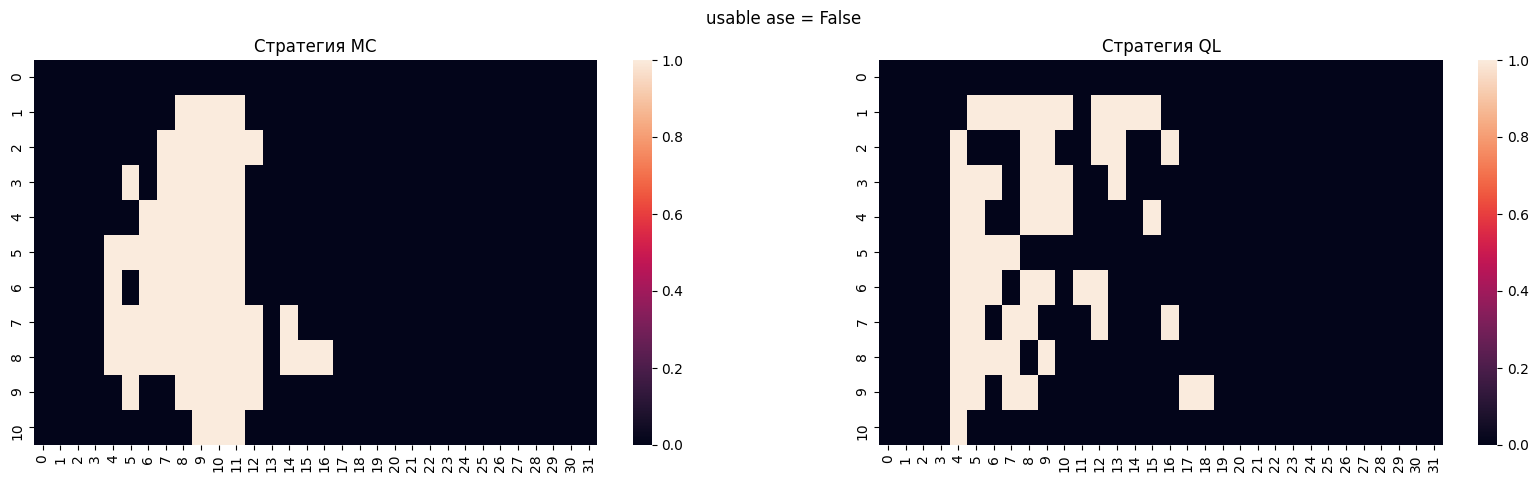

In [25]:
# Посмотрим, как отличаются действия стратегий MC и  QL
fig, [ax0, ax1] = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
plt.suptitle('usable ase = False')
sns.heatmap(pi_MC[:, :, 0].T, ax=ax0)
ax0.set_title('Стратегия MC')
sns.heatmap(pi_QL[:, :, 0].T, ax=ax1)
ax1.set_title('Стратегия QL')
plt.show(fig)

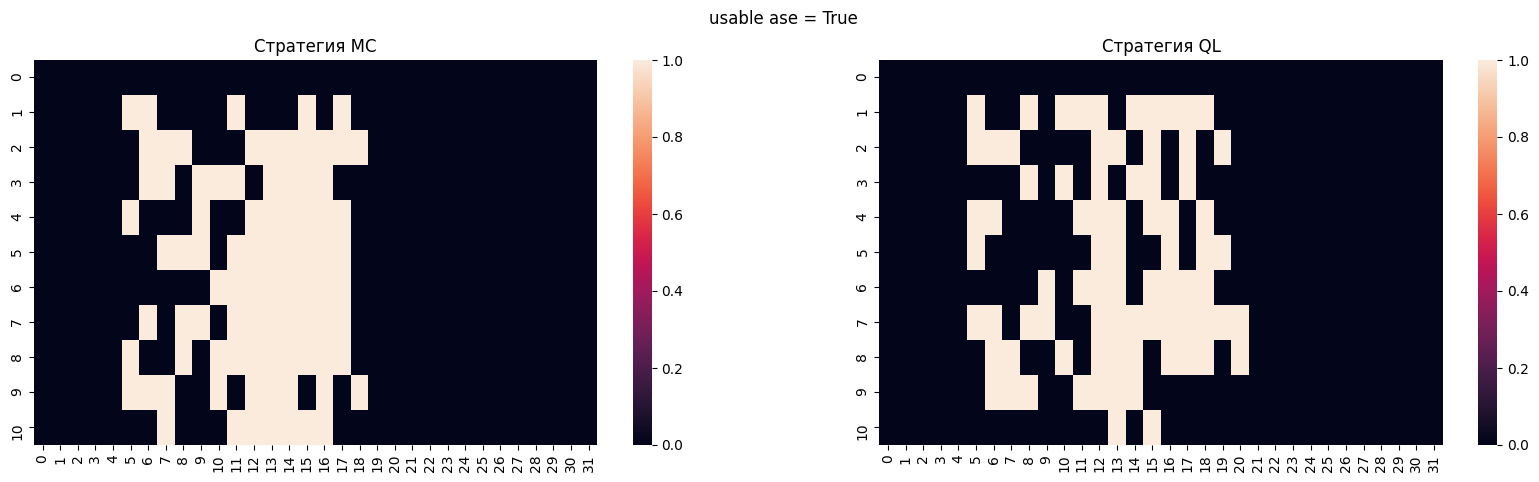

In [26]:
# Посмотрим, как отличаются действия стратегий MC и  QL
fig, [ax0, ax1] = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
plt.suptitle('usable ase = True')
sns.heatmap(pi_MC[:, :, 1].T, ax=ax0)
ax0.set_title('Стратегия MC')
sns.heatmap(pi_QL[:, :, 1].T, ax=ax1)
ax1.set_title('Стратегия QL')
plt.show(fig)

# 1.3 Подбор гиперпараметров (MC)

In [10]:
from utils import (
    params_grid_MC,
    learning_loop_MC,
    plot_learning_curve_MC
)

hyper params estimation...: 100%|██████████| 5/5 [07:47<00:00, 93.50s/it]


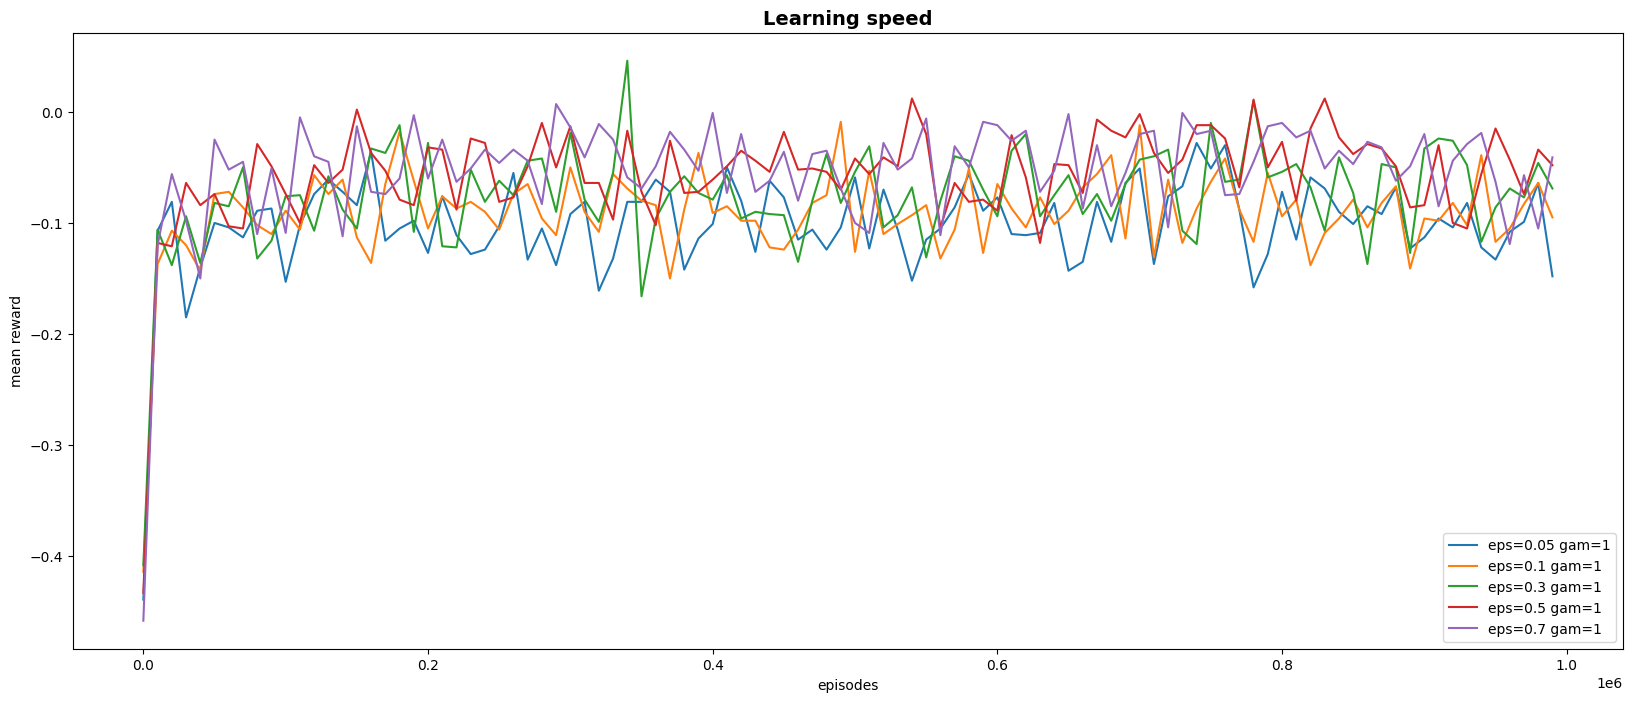

In [16]:
# построим графики обучения для различных гиперпараметров (см. набор параметров в функции params_grid)
learning_results_lst = []

Q_rand = get_random_Q(state_space_size + [nA]) # ~ пространство < 1_000 точек
pi_rand = compute_policy_by_Q(Q_rand)
C = np.zeros(state_space_size + [nA], dtype=float)

for param in tqdm.tqdm(params_grid_MC(), total=len(list(params_grid_MC())), desc='hyper params estimation...'):

    learning_results_dct = learning_loop_MC(env=env, 
                                         pi=np.copy(pi_rand), 
                                         Q=np.copy(Q_rand), 
                                         C=np.copy(C),
                                         epsilon=param['epsilon'], 
                                         gamma=param['gamma'], 
                                         total_episodes=1_000_000, 
                                         pi_score_step=10_000)
    learning_results_lst.append(learning_results_dct)

plot_learning_curve_MC(learning_results_lst)

In [17]:
print('%10s %10s %10s' % ('gamma', 'epsilon', 'score'))
for i in learning_results_lst: #
    print('%10s %10s %10s' % (i['gamma'], i['epsilon'], round(score_pi(env, i['pi']), 3)))

     gamma    epsilon      score
         1       0.05     -0.092
         1        0.1     -0.086
         1        0.3     -0.072
         1        0.5     -0.053
         1        0.7     -0.046


Лучший результат -0.046

# 1.3 Подбор гиперпараметров (QL)

In [14]:
from utils import (
    params_grid,
    learning_loop,
    plot_learning_curve
)

hyper params estimation...: 100%|██████████| 9/9 [02:23<00:00, 15.89s/it]


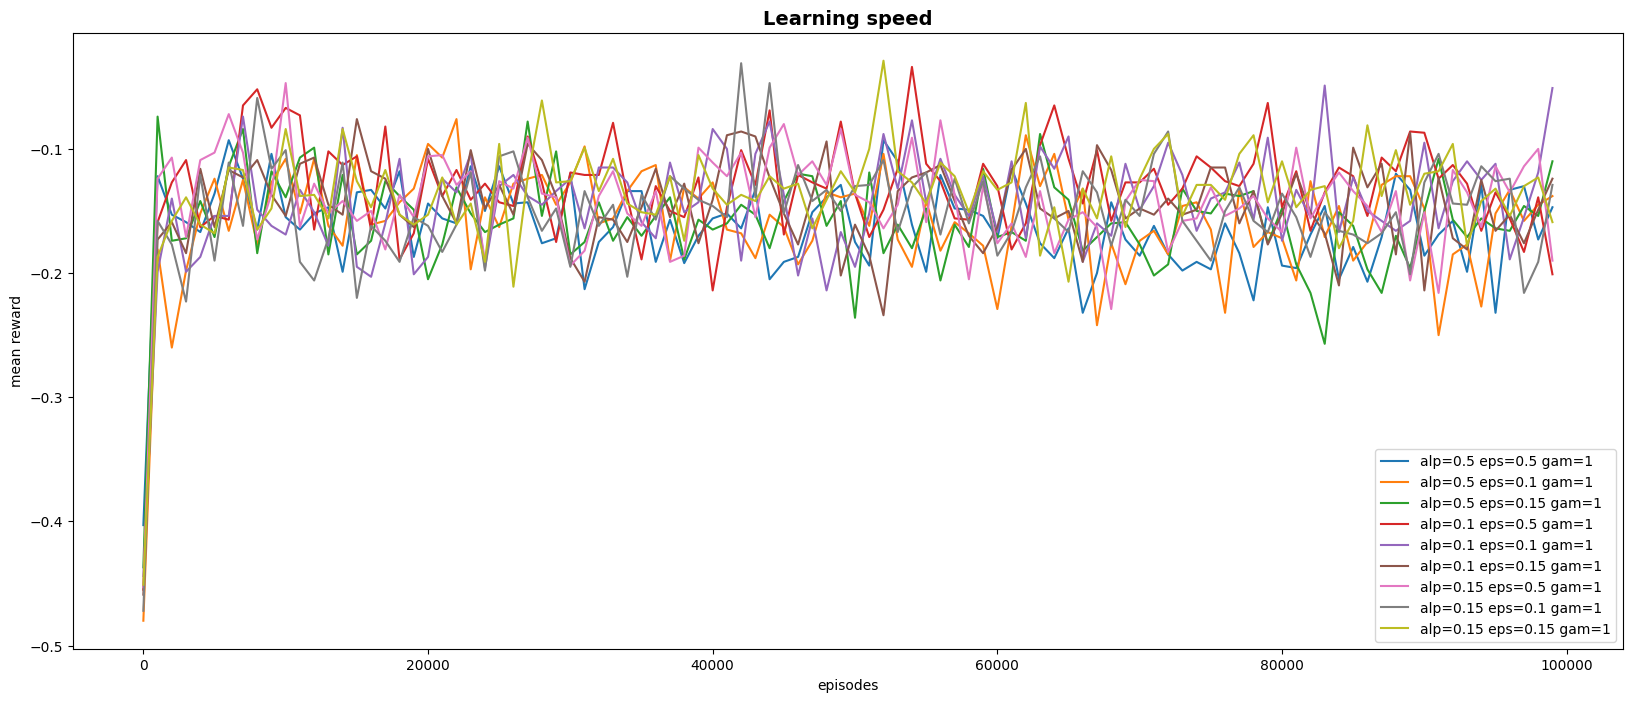

In [35]:
# построим графики обучения для различных гиперпараметров (см. набор в функции params_grid)
learning_results_lst = []
Q_rand = get_random_Q(state_space_size + [nA]) # ~ пространство < 1_000 точек
pi_rand = compute_policy_by_Q(Q_rand)

for param in tqdm.tqdm(params_grid(), total=len(list(params_grid())), desc='hyper params estimation...'):
    
    learning_results_dct = learning_loop(env=env, 
                                         pi=np.copy(pi_rand), 
                                         Q=np.copy(Q_rand), 
                                         alpha=param['alpha'], 
                                         epsilon=param['epsilon'], 
                                         gamma=param['gamma'], 
                                         total_episodes=100_000, 
                                         pi_score_step=1_000)
    learning_results_lst.append(learning_results_dct)

plot_learning_curve(learning_results_lst)

In [36]:
print('%10s %10s %10s %10s' % ('gamma', 'epsilon', 'alpha', 'score'))
for i in learning_results_lst: #
    print('%10s %10s %10s %10s' % (i['gamma'], i['epsilon'],  i['alpha'], round(score_pi(env, i['pi']), 3)))

     gamma    epsilon      alpha      score
         1        0.5        0.5     -0.175
         1        0.1        0.5     -0.163
         1       0.15        0.5     -0.167
         1        0.5        0.1     -0.124
         1        0.1        0.1     -0.126
         1       0.15        0.1     -0.133
         1        0.5       0.15     -0.152
         1        0.1       0.15     -0.153
         1       0.15       0.15      -0.15


Подбор гиперпараметров не позволил найти стратегию QL, которая бы превзошла MC стратегию.

# 2.4 - 2.5 Удвоение ставки (MC)

In [18]:
from BJ_env_double import BlackjackDoubleEnv
env_double = BlackjackDoubleEnv()
env_double.action_space # 'double' = 2, 'hit' = 1, 'stick' = 0
nA_double = 3

hyper params estimation...: 100%|██████████| 5/5 [07:50<00:00, 94.12s/it]


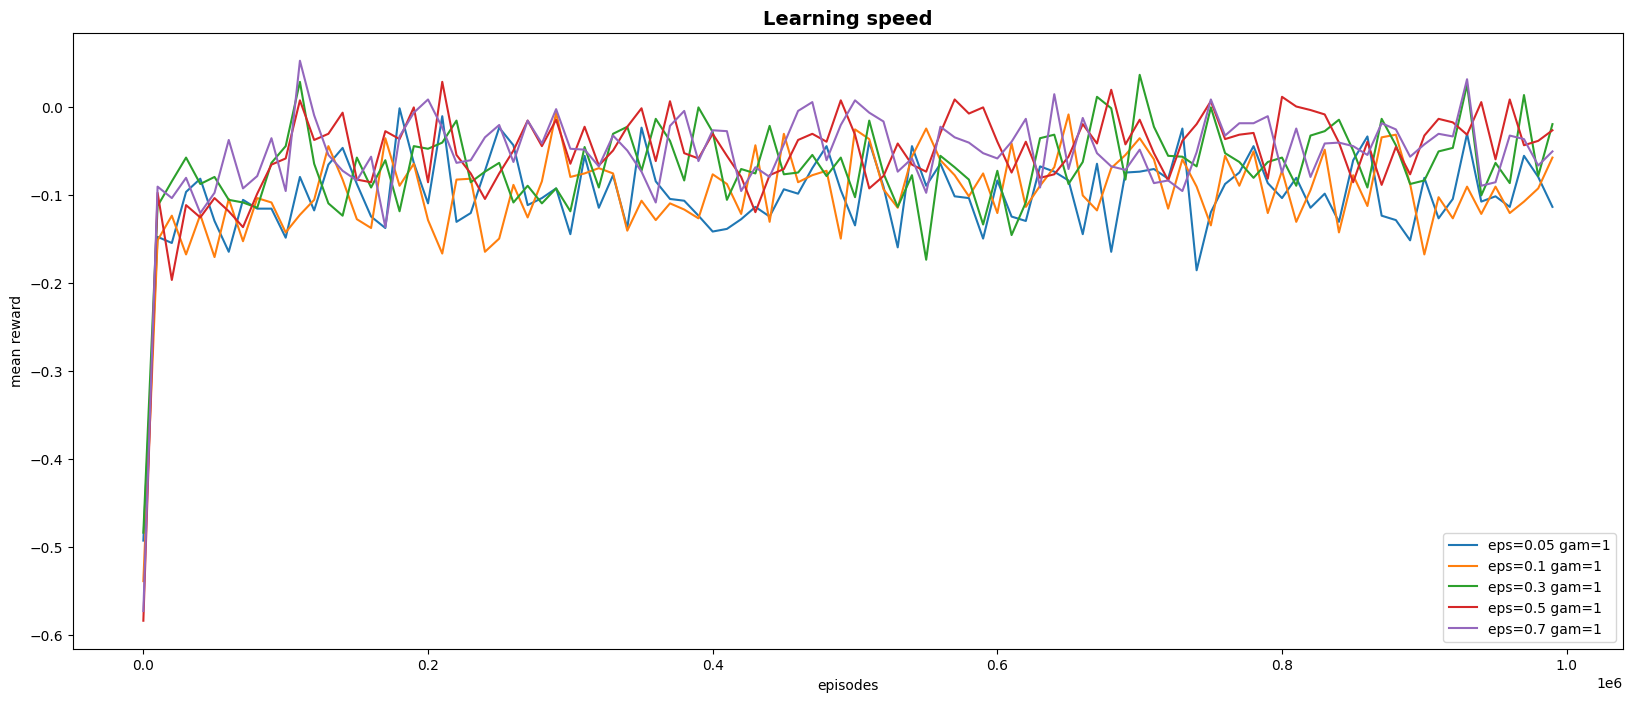

In [19]:
# построим графики обучения для различных гиперпараметров (см. набор параметров в функции params_grid)
learning_results_lst = []

Q_rand = get_random_Q(state_space_size + [nA_double]) # пространство ~ 1_000 точек
pi_rand = compute_policy_by_Q(Q_rand)
C = np.zeros(state_space_size + [nA_double], dtype=float)

for param in tqdm.tqdm(params_grid_MC(), total=len(list(params_grid_MC())), desc='hyper params estimation...'):

    learning_results_dct = learning_loop_MC(env=env_double, 
                                         pi=np.copy(pi_rand), 
                                         Q=np.copy(Q_rand), 
                                         C=np.copy(C),
                                         epsilon=param['epsilon'], 
                                         gamma=param['gamma'], 
                                         total_episodes=1_000_000, 
                                         pi_score_step=10_000)
    learning_results_lst.append(learning_results_dct)

plot_learning_curve_MC(learning_results_lst)

In [20]:
print('%10s %10s %10s' % ('gamma', 'epsilon', 'score'))
for i in learning_results_lst: #
    print('%10s %10s %10s' % (i['gamma'], i['epsilon'], round(score_pi(env_double, i['pi']), 3)))

     gamma    epsilon      score
         1       0.05     -0.093
         1        0.1     -0.082
         1        0.3     -0.061
         1        0.5     -0.038
         1        0.7     -0.042


Добавление действия double позволило улучшить MC стратегию -0.046 ---> -0.038

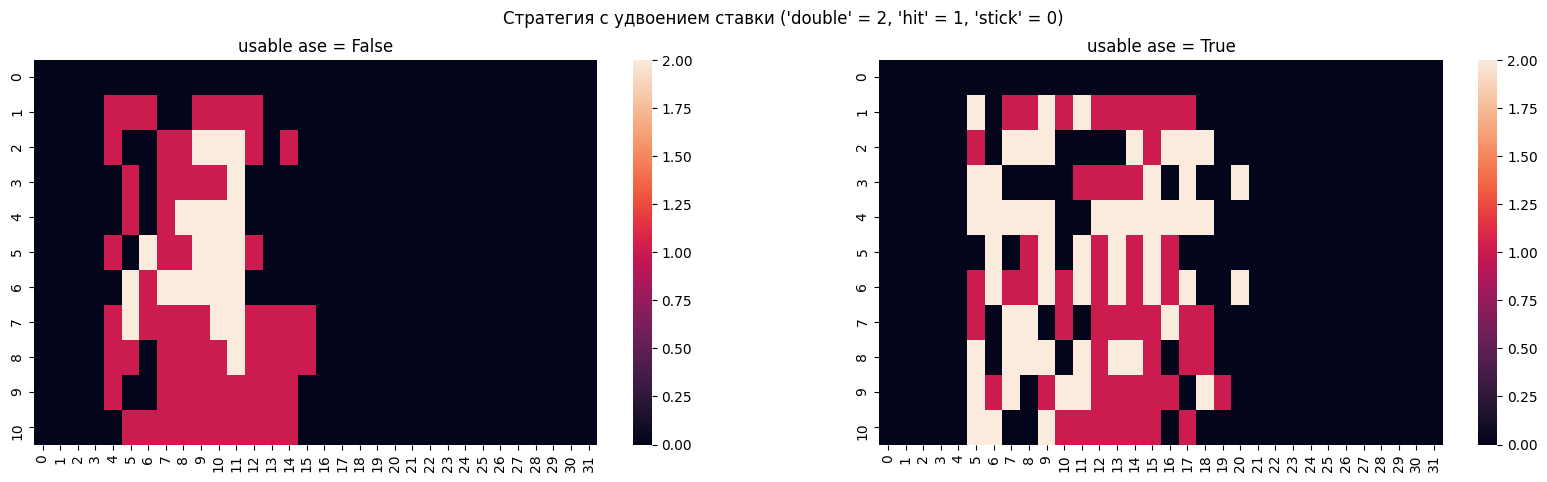

In [44]:
# Посмотрим, в какие моменты предлагается удвоить ставку
pi_double = learning_results_lst[-1]['pi']
fig, [ax0, ax1] = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
plt.suptitle("Стратегия с удвоением ставки ('double' = 2, 'hit' = 1, 'stick' = 0)")
sns.heatmap(pi_rand[:, :, 0].T, ax=ax0)
ax0.set_title('usable ase = False')
sns.heatmap(pi_rand[:, :, 1].T, ax=ax1)
ax1.set_title('usable ase = True')
plt.show(fig)

Видно, что при usable ase = True игра более рискованная (происходит добор карт, удвоения ставки даже когда на руках большая сумма).
<br> Это объясняется тем, что из usable ase = True в случае перебора сумма карт на руках понизится за счет перехода тузов 11 -> 1, но игра продолжится!

# 2.4 - 2.5 Удвоение ставки (QL)

hyper params estimation...: 100%|██████████| 9/9 [02:30<00:00, 16.74s/it]


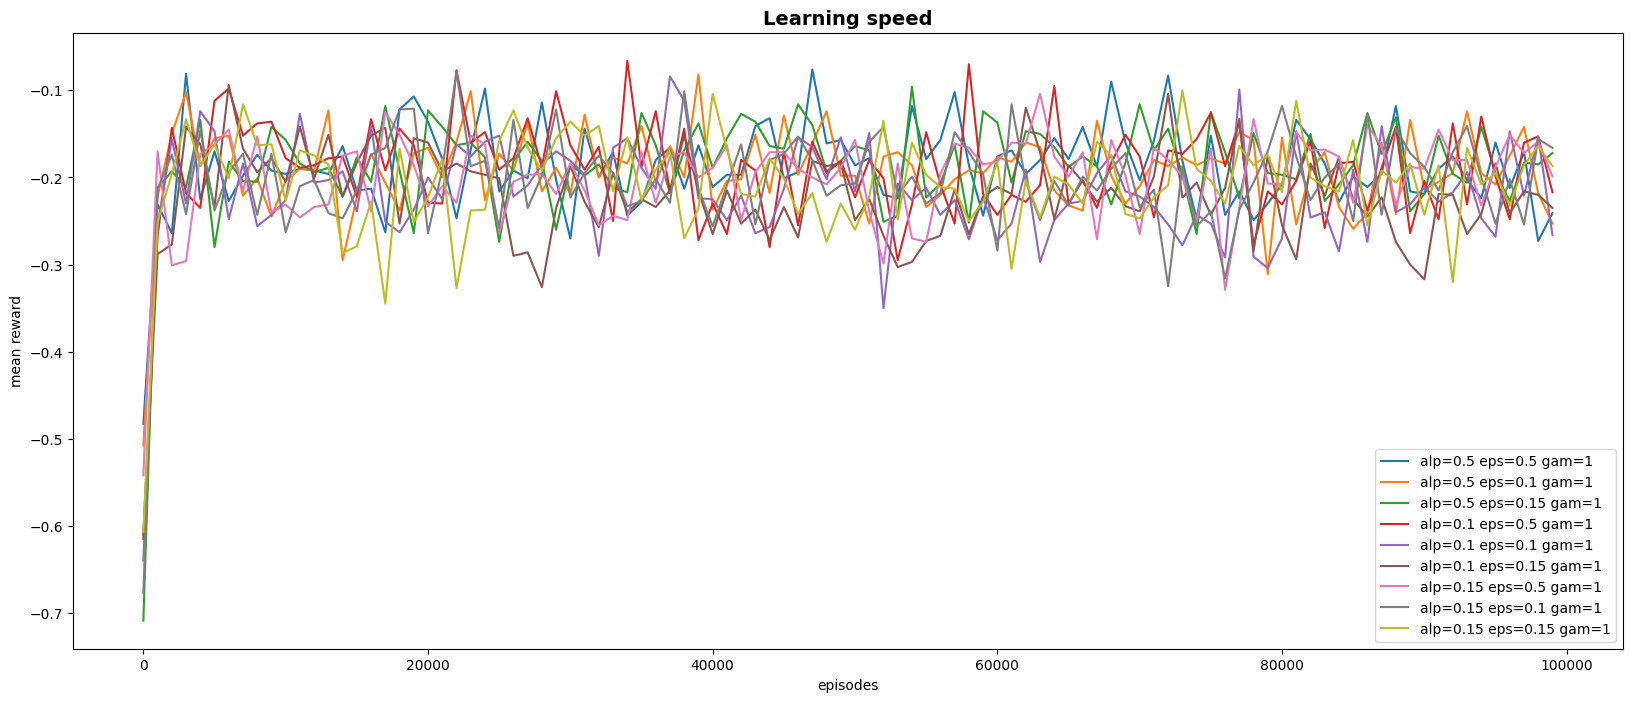

In [31]:
# построим графики обучения для различных гиперпараметров (см. набор в функции params_grid)
learning_results_lst = []
Q_rand = get_random_Q(state_space_size + [nA_double]) # пространство ~ 1_000 точек
pi_rand = compute_policy_by_Q(Q_rand)

for param in tqdm.tqdm(params_grid(), total=len(list(params_grid())), desc='hyper params estimation...'):
    
    learning_results_dct = learning_loop(env=env_double, 
                                         pi=np.copy(pi_rand), 
                                         Q=np.copy(Q_rand), 
                                         alpha=param['alpha'], 
                                         epsilon=param['epsilon'], 
                                         gamma=param['gamma'], 
                                         total_episodes=100_000, 
                                         pi_score_step=1_000)
    learning_results_lst.append(learning_results_dct)

plot_learning_curve(learning_results_lst)

In [32]:
print('%10s %10s %10s %10s' % ('gamma', 'epsilon', 'alpha', 'score'))
for i in learning_results_lst: #
    print('%10s %10s %10s %10s' % (i['gamma'], i['epsilon'],  i['alpha'], round(score_pi(env_double, i['pi']), 3)))

     gamma    epsilon      alpha      score
         1        0.5        0.5     -0.199
         1        0.1        0.5       -0.2
         1       0.15        0.5     -0.203
         1        0.5        0.1     -0.173
         1        0.1        0.1     -0.259
         1       0.15        0.1     -0.209
         1        0.5       0.15     -0.164
         1        0.1       0.15     -0.199
         1       0.15       0.15      -0.22


Подбор гиперпараметров не позволил найти стратегию QL, которая бы превзошла MC стратегию.

# 3.6 - 3.7 Подсчет карт (MC)

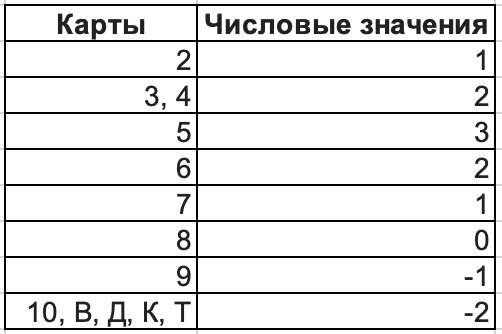

In [22]:
display.Image("cards_score.png", width=200, height=200)

Реализуем подсчет карт в соответстви с таблицей выше (подробнее см. по ссылке https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA)
<br>Тогда значение в колоде может менять от -44 до 22.
<br>Добавим в пространство состояний новое измерение из 67 возможных состояний.
<br>Если в колоде остается меньше 15 карт - выполняем перемешивание.

In [21]:
from BJ_env_counting import BlackjackCountingEnv
env_counting = BlackjackCountingEnv()
nA_counting = 3
state_space_size_counting = [32, 11, 2, 89] # из них эффективное (используемое) пространство ~ 32_000 точек

hyper params estimation...: 100%|██████████| 1/1 [1:13:59<00:00, 4439.33s/it]


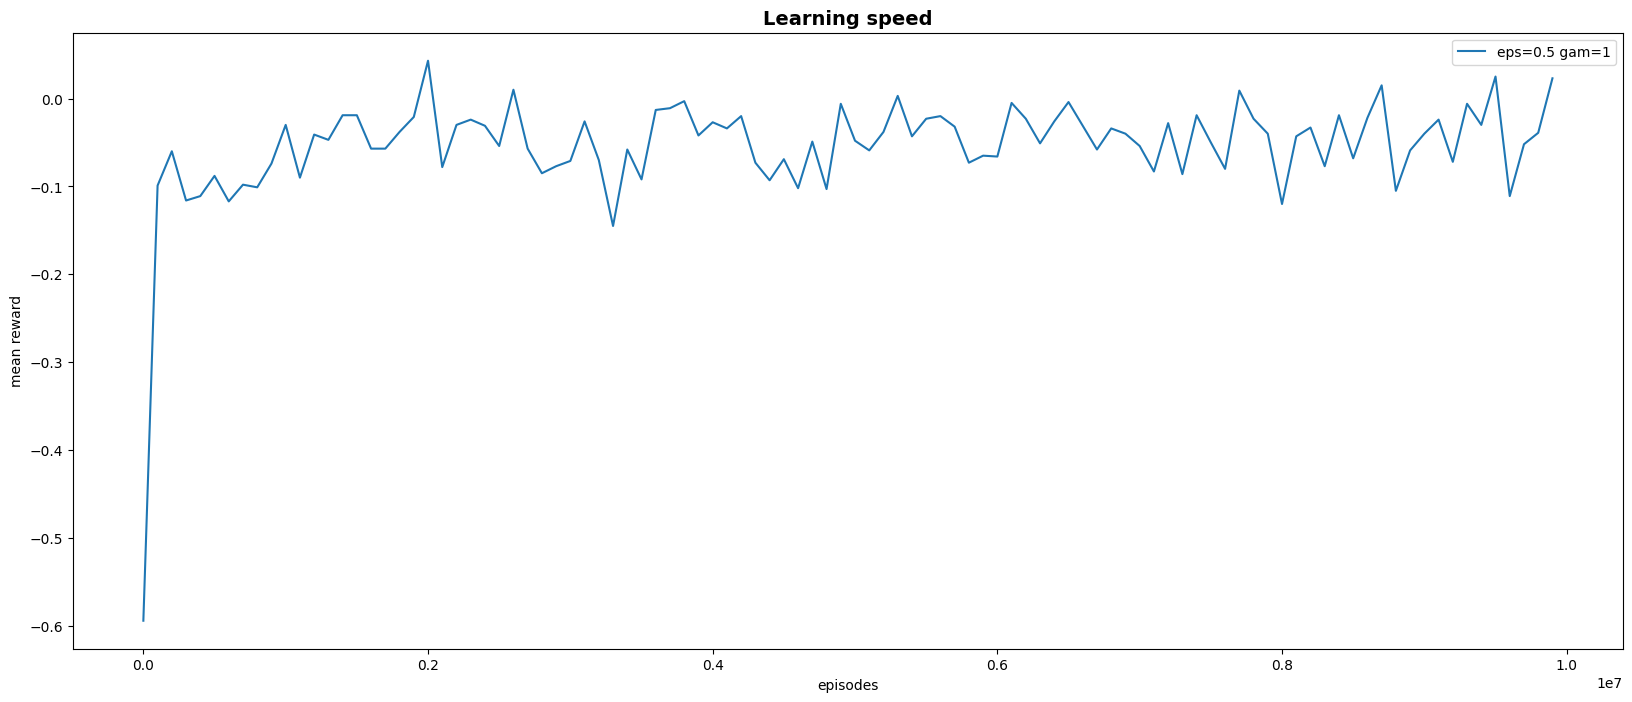

In [4]:
# построим графики обучения для различных гиперпараметров (см. набор параметров в функции params_grid)
learning_results_lst = []

Q_rand = get_random_Q(state_space_size_counting + [nA_counting]) # пространство ~ 100_000 точек
pi_rand = compute_policy_by_Q(Q_rand)
C = np.zeros(state_space_size_counting + [nA_counting], dtype=float)

for param in tqdm.tqdm(
    params_grid_MC(gam_lst=[1], eps_lst=[0.5]), 
    total=len(list(params_grid_MC(gam_lst=[1], eps_lst=[0.5]))), 
    desc='hyper params estimation...'):

    learning_results_dct = learning_loop_MC(env=env_counting, 
                                         pi=np.copy(pi_rand), 
                                         Q=np.copy(Q_rand), 
                                         C=np.copy(C),
                                         epsilon=param['epsilon'], 
                                         gamma=param['gamma'], 
                                         total_episodes=10_000_000, 
                                         pi_score_step=100_000)
    learning_results_lst.append(learning_results_dct)

plot_learning_curve_MC(learning_results_lst)

In [5]:
print('%10s %10s %10s' % ('gamma', 'epsilon', 'score'))
for i in learning_results_lst: #
    print('%10s %10s %10s' % (i['gamma'], i['epsilon'], round(score_pi(env_counting, i['pi']), 3)))

     gamma    epsilon      score
         1        0.5     -0.032


Подсчет карт позволил еще улучшить MC стратегию -0.046 ---> -0.038 ---> -0.032

# 3.6 - 3.7 Подсчет карт (QL)

hyper params estimation...: 100%|██████████| 1/1 [1:13:16<00:00, 4396.41s/it]


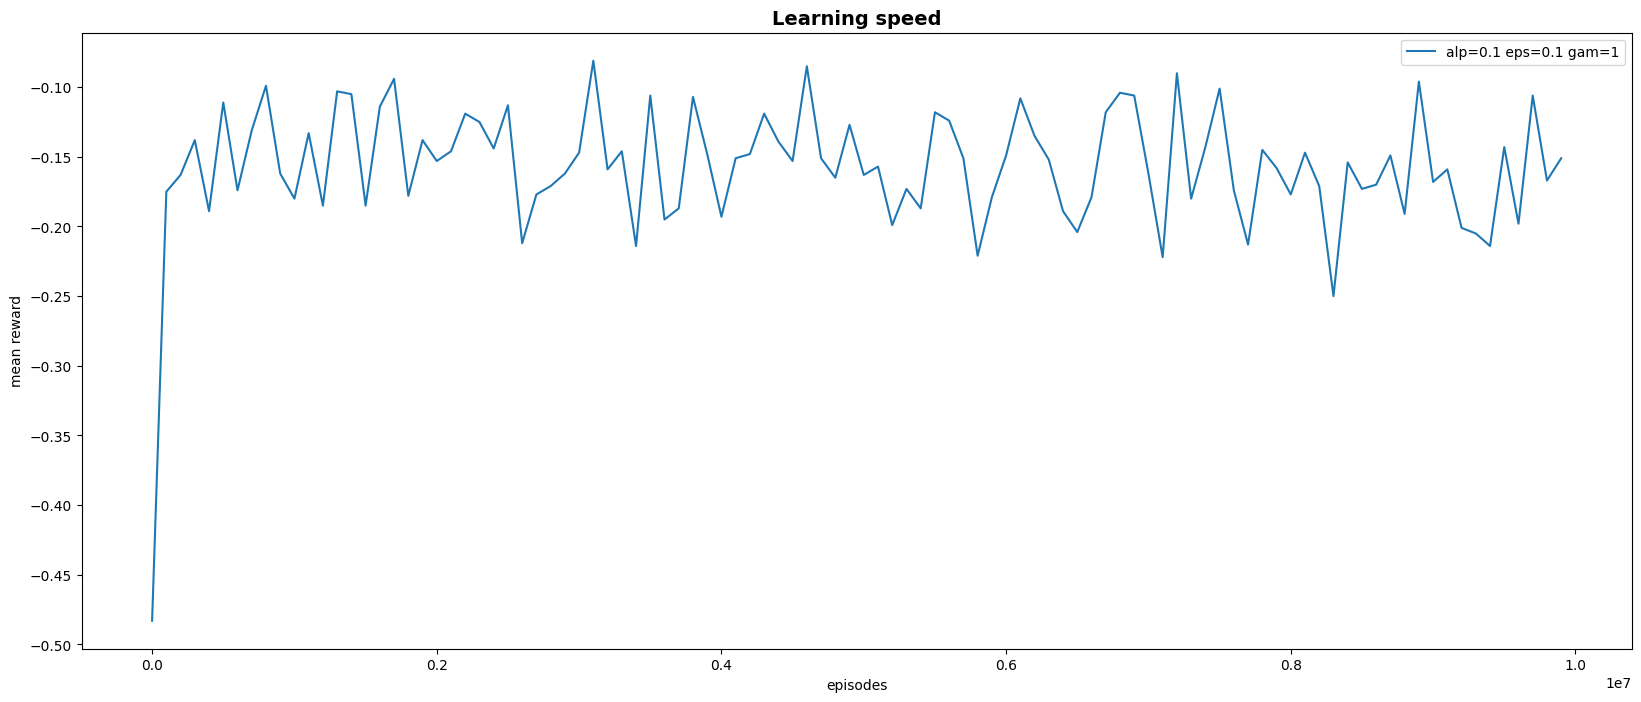

In [6]:
# построим графики обучения для различных гиперпараметров (см. набор параметров в функции params_grid)
learning_results_lst = []

Q_rand = get_random_Q(state_space_size_counting + [nA_counting]) # пространство ~ 100_000 точек
pi_rand = compute_policy_by_Q(Q_rand)

for param in tqdm.tqdm(
    params_grid(gam_lst=[1], alp_lst=[0.1], eps_lst=[0.1]), 
    total=len(list(params_grid(gam_lst=[1], alp_lst=[0.1], eps_lst=[0.1]))), 
    desc='hyper params estimation...'):

    learning_results_dct = learning_loop(env=env_counting, 
                                         pi=np.copy(pi_rand), 
                                         Q=np.copy(Q_rand), 
                                         alpha=param['alpha'], 
                                         epsilon=param['epsilon'], 
                                         gamma=param['gamma'], 
                                         total_episodes=10_000_000, 
                                         pi_score_step=100_000)
    learning_results_lst.append(learning_results_dct)

plot_learning_curve(learning_results_lst)

In [7]:
print('%10s %10s %10s %10s' % ('gamma', 'epsilon', 'alpha', 'score'))
for i in learning_results_lst: #
    print('%10s %10s %10s %10s' % (i['gamma'], i['epsilon'],  i['alpha'], round(score_pi(env_counting, i['pi']), 3)))

     gamma    epsilon      alpha      score
         1        0.1        0.1     -0.166


Подсчет карт позволил улучшить Q-learning стратегию для таких же параметров (-0.259 ---> -0.166).
<br>Тем не меннее, получается стратегия значительно хуже стратегии полученной через MC off-policy control (-0.032).